# Forecast Consumption

Forecasting using timeseries model the consumption of water, gas and electricity.



In [ ]:
# from pathlib import Path
# import sys
# import pandas as pd

# sys.path.append(str(Path.cwd().parents[0]))
# from core.data_manager import read_data_csv_df


# # function to read the data
# def read_data_csv_df(directory: str, filename: str) -> pd.DataFrame:
#     path=Path.cwd().parents[0]
#     try:
#         df = pd.read_csv(path.joinpath(directory,filename))
#         return df
#     except FileNotFoundError:
#         print(f"File {filename} not found")
#         print("Please verify the file name and try again, and path")
#         exit()

# df = read_data_csv_df("data_storage", "resampled_data_D_gas.csv")


# "data_storage", "resampled_data_D_gas.csv"

# df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_gas.csv"))
# df.columns
# print(df.columns)

## Preparing the data

In [1]:
# Import the necessary libraries
import sys
import pandas as pd
from os import path
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sys.path.append('../../')
# from core.settings import gas_monthly_df

In [2]:
# variables


path = Path.cwd().parents[0]


# gas_daily_df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_gas.csv"))
# water_daily_df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_water.csv"))
power_daily_df = pd.read_csv(
    path.joinpath("data_storage", "resampled_data_D_power.csv")
)

In [3]:
# gas_daily_df.info()
# # gas_monthly_df.describe()

power_daily_df.info()
# power_monthly_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       4837 non-null   object 
 1   id_meter   4837 non-null   float64
 2   power_kwh  4837 non-null   float64
 3   calc_cons  4834 non-null   float64
dtypes: float64(3), object(1)
memory usage: 151.3+ KB


In [4]:
# show duplicate dates in the data
power_daily_df[power_daily_df.duplicated(subset=["date"], keep=False)]

,date,id_meter,power_kwh,calc_cons
0,2014-09-04,4.0,51419.300000,NaN
1,2014-09-05,4.0,51422.141748,2.841748
2,2014-09-06,4.0,51424.983495,2.841748
3,2014-09-07,4.0,51427.825243,2.841748
4,2014-09-08,4.0,51430.666990,2.841748
...,...,...,...,...
4832,2014-11-24,7.0,2232.200000,0.000000
4833,2014-11-25,7.0,2232.200000,0.000000
4834,2014-11-26,7.0,2232.200000,0.000000
4835,2014-11-27,7.0,2232.200000,0.000000


In [5]:
# sort by date
power_daily_df.sort_values(by=["date"], inplace=True)
# show date 2021-04-01
power_daily_df[power_daily_df["date"] < "2021-04-03"]

,date,id_meter,power_kwh,calc_cons
3560,2011-06-01,7.0,0.000000,NaN
3561,2011-06-02,7.0,1.831173,1.831173
3562,2011-06-03,7.0,3.662346,1.831173
3563,2011-06-04,7.0,5.493519,1.831173
3564,2011-06-05,7.0,7.324692,1.831173
...,...,...,...,...
2399,2021-03-29,5.0,94.914286,3.328571
2400,2021-03-30,5.0,98.242857,3.328571
2401,2021-03-31,5.0,101.571429,3.328571
2402,2021-04-01,5.0,104.900000,3.328571


In [6]:
print(power_daily_df.head())
# Dealing with missing values
# # show NaN values rows
# gas_monthly_df[gas_monthly_df.isnull().any(axis=1)]

# # show duplicate rows
# gas_monthly_df[gas_monthly_df.duplicated()]

# # show rows for date 2014-09-04
# gas_monthly_df[gas_monthly_df['date'] == '2014-09-04']

# agregate by id_meter, date
power_daily_df = power_daily_df.groupby(["id_meter", "date"]).agg("sum").reset_index()

# agregate by date, if id_meter is the same, sum the values, else keep both values
power_daily_df = (
    power_daily_df.groupby(["date"])
    .agg(
        {
            "calc_cons": "sum",
            "id_meter": lambda x: ", ".join(map(str, x)),
        }
    )
    .reset_index()
)

# in the column id_meter, keep only one value
power_daily_df["id_meter"] = power_daily_df["id_meter"].apply(lambda x: x.split(",")[0])

# convert id_meter to float
power_daily_df["id_meter"] = power_daily_df["id_meter"].astype(float)

# # in the column id_meter, keep only the value that is last in the list
# power_daily_df["id_meter"] = power_daily_df["id_meter"].apply(
#     lambda x: x.split(",")[-1]
# )
# # remove empty spaces in the column id_meter
# power_daily_df["id_meter"] = power_daily_df["id_meter"].str.strip()

# fill row 0 NaN value with 0
power_daily_df = power_daily_df.fillna(0, inplace=False)

# drop duplicate rows keeping the last row
power_daily_df.drop_duplicates(subset=["date"], keep="last", inplace=True)

# # show duplicate dates rows
# gas_monthly_df[gas_monthly_df.duplicated(['date'])]

# # # drop duplicate dates rows
# # gas_monthly_df.drop_duplicates(subset=['date'], inplace=False)

# convert date column to datetime
power_daily_df["date"] = pd.to_datetime(power_daily_df["date"])


power_daily_df.info()

# # verify that there are not missing dates in the data
# gas_monthly_df['date'] = pd.to_datetime(gas_monthly_df['date'])
# gas_monthly_df['date'].diff().dt.days

            date  id_meter  power_kwh  calc_cons
3560  2011-06-01       7.0   0.000000        NaN
3561  2011-06-02       7.0   1.831173   1.831173
3562  2011-06-03       7.0   3.662346   1.831173
3563  2011-06-04       7.0   5.493519   1.831173
3564  2011-06-05       7.0   7.324692   1.831173
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4750 non-null   datetime64[ns]
 1   calc_cons  4750 non-null   float64       
 2   id_meter   4750 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 111.5 KB


In [7]:
# drop columns not columns 1 to 3
# gas_daily_df = gas_daily_df.drop(gas_daily_df.columns[1:3], axis=1, inplace=False)

power_daily_df.head()

# unique values in id_meter column
power_daily_df["id_meter"].unique()

# # show values with id_meter == 11
# power_daily_df[power_daily_df['id_meter'] == 11]

array([7., 4., 5.])

In [8]:
# show 0 values in calc_cons column
power_daily_df[power_daily_df["calc_cons"] == 0]

,date,calc_cons,id_meter
0,2011-06-01,0.0,7.0


In [9]:
# show duplicate dates rows
power_daily_df[power_daily_df.duplicated(["date"])]

,date,calc_cons,id_meter


In [ ]:
# # convert date column to datetime
# power_daily_df["date"] = pd.to_datetime(power_daily_df["date"])
# # set date column as index
# power_daily_df.set_index("date", inplace=True)

In [10]:
# sort by date
power_daily_df = power_daily_df.sort_values(by="date")

In [11]:
power_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4750 non-null   datetime64[ns]
 1   calc_cons  4750 non-null   float64       
 2   id_meter   4750 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 111.5 KB


In [12]:
power_daily_df.describe()

,date,calc_cons,id_meter
count,4750,4750.000000,4750.000000
mean,2017-11-30 12:00:00,2.490211,5.001684
min,2011-06-01 00:00:00,0.000000,4.000000
25%,2014-08-31 06:00:00,1.831173,4.000000
50%,2017-11-30 12:00:00,2.461429,5.000000
75%,2021-03-01 18:00:00,3.122581,7.000000
max,2024-06-01 00:00:00,4.672921,7.000000
std,NaN,0.927730,1.225990


## Prepare the model

In [ ]:
# # subsample the data to hourly
# gas_hourly_df = gas_daily_df.resample('h').mean()

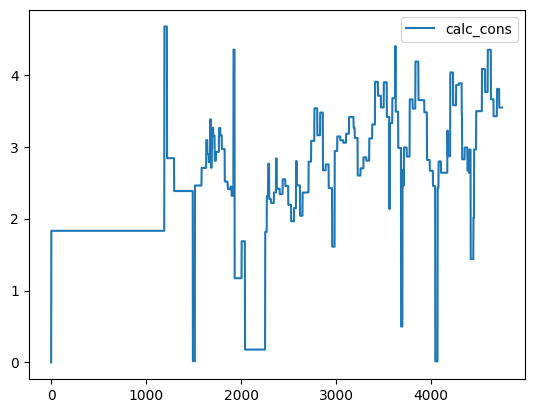

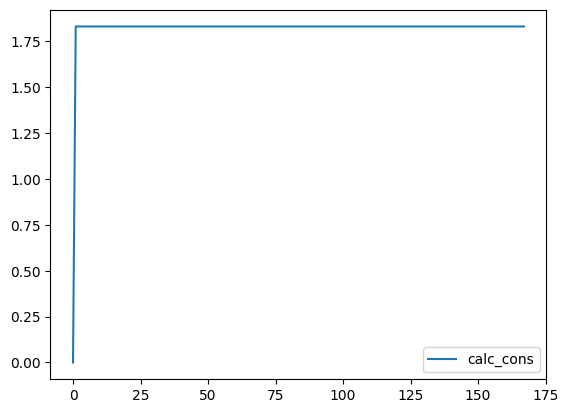

In [14]:
# list with the column defined by position 1, 2 in the axis 1
plot_cols = power_daily_df.columns[1:2]
plot_features = power_daily_df[plot_cols]
plot_features.index = power_daily_df.index
_ = plot_features.plot(subplots=True)

plot_features = power_daily_df[plot_cols][:168]
plot_features.index = power_daily_df.index[:168]
_ = plot_features.plot(subplots=True)

## Featured Engineering

In [15]:
# convert time
# convert date to seconds to made it more readable
power_daily_df["date"] = pd.to_datetime(power_daily_df["date"])

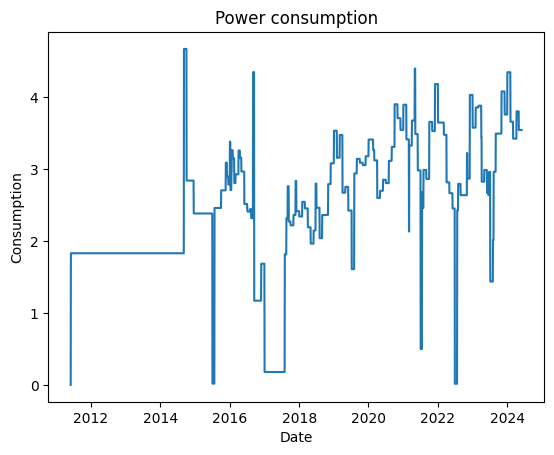

In [16]:
# assuming daily, weekly, monthly, yearly perioditicity
# daily
power_daily_df["day"] = power_daily_df["date"].dt.day
power_daily_df["month"] = power_daily_df["date"].dt.month
power_daily_df["year"] = power_daily_df["date"].dt.year
power_daily_df["dayofweek"] = power_daily_df["date"].dt.dayofweek
power_daily_df["dayofyear"] = power_daily_df["date"].dt.dayofyear
# power_daily_df["week"] = power_daily_df["date"].dt.week
power_daily_df["quarter"] = power_daily_df["date"].dt.quarter

# # weekly
# power_daily_df["week"] = power_daily_df["date"].dt.week

# monthly
power_daily_df["month"] = power_daily_df["date"].dt.month

# yearly
power_daily_df["year"] = power_daily_df["date"].dt.year

# show the first rows
power_daily_df.head()

# plot the data
plt.plot(np.array(power_daily_df["date"]), np.array(power_daily_df["calc_cons"]))
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Power consumption")
plt.show()

# plt.plot(np.array(power_daily_df["day"]), np.array(power_daily_df["calc_cons"]))
# plt.xlabel("Day")
# plt.ylabel("Consumption")
# plt.title("Power consumption")
# plt.show()

Text(0.5, 1.0, 'Time of day signal')

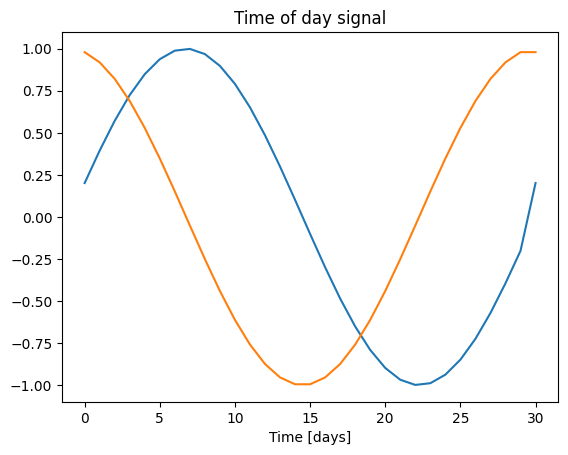

In [17]:
# using cosine and sine to encode the cyclical nature of time
# day
power_daily_df["day_sin"] = np.sin(power_daily_df["day"] * (2 * np.pi / 31))
power_daily_df["day_cos"] = np.cos(power_daily_df["day"] * (2 * np.pi / 31))
# month
power_daily_df["month_sin"] = np.sin(power_daily_df["month"] * (2 * np.pi / 12))
power_daily_df["month_cos"] = np.cos(power_daily_df["month"] * (2 * np.pi / 12))
# year
power_daily_df["year_sin"] = np.sin(power_daily_df["year"] * (2 * np.pi / 2021))
power_daily_df["year_cos"] = np.cos(power_daily_df["year"] * (2 * np.pi / 2021))
# dayofweek
power_daily_df["dayofweek_sin"] = np.sin(power_daily_df["dayofweek"] * (2 * np.pi / 7))
power_daily_df["dayofweek_cos"] = np.cos(power_daily_df["dayofweek"] * (2 * np.pi / 7))
# dayofyear
power_daily_df["dayofyear_sin"] = np.sin(
    power_daily_df["dayofyear"] * (2 * np.pi / 366)
)
power_daily_df["dayofyear_cos"] = np.cos(
    power_daily_df["dayofyear"] * (2 * np.pi / 366)
)
# quarter
power_daily_df["quarter_sin"] = np.sin(power_daily_df["quarter"] * (2 * np.pi / 4))
power_daily_df["quarter_cos"] = np.cos(power_daily_df["quarter"] * (2 * np.pi / 4))

# # show the first rows
power_daily_df.head()

plt.plot(np.array(power_daily_df["day_sin"])[:31])
plt.plot(np.array(power_daily_df["day_cos"])[:31])
plt.xlabel("Time [days]")
plt.title("Time of day signal")

Fast Fourier Transform???

In [18]:
# Split the data
# split the data into train, validation, and test set
# train set is 70% of the data
# validation set is 15% of the data
# test set is 15% of the data
n = len(power_daily_df)
train_df = power_daily_df[0 : int(n * 0.7)]
val_df = power_daily_df[int(n * 0.7) : int(n * 0.85)]
test_df = power_daily_df[int(n * 0.85) :]
# check the length of the data
print(len(train_df), len(val_df), len(test_df))

num_features = power_daily_df.shape[1]

print(f"Number of features = {num_features}")

3325 712 713
Number of features = 21


In [19]:
# Normalize the data
# normalize the data using the mean and standard deviation of the training data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# # show the first rows
train_df.head()

C:\Users\zudel\AppData\Local\Temp\ipykernel_31580\1963666855.py:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train_df = (train_df - train_mean) / train_std
C:\Users\zudel\AppData\Local\Temp\ipykernel_31580\1963666855.py:7: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val_df = (val_df - train_mean) / train_std
C:\Users\zudel\AppData\Local\Temp\ipykernel_31580\1963666855.py:8: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_df = (test_df - train_mean) / train_std


,date,calc_cons,id_meter,day,month,year,dayofweek,dayofyear,quarter,day_sin,...,month_sin,month_cos,year_sin,year_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,quarter_sin,quarter_cos
0,-1.73127,-2.714939,1.338369,-1.669404,-0.151047,-1.679387,-0.499925,-0.295327,-0.453672,0.278432,...,0.007956,-1.386756,-1.679238,-2.067633,1.378549,-0.314645,0.716826,-1.195648,0.009397,-1.399038
1,-1.730228,-0.423943,1.338369,-1.555884,-0.151047,-1.679387,0.0,-0.285791,-0.453672,0.549041,...,0.007956,-1.386756,-1.679238,-2.067633,0.613512,-1.273971,0.695724,-1.207742,0.009397,-1.399038
2,-1.729186,-0.423943,1.338369,-1.442365,-0.151047,-1.679387,0.499925,-0.276254,-0.453672,0.797019,...,0.007956,-1.386756,-1.679238,-2.067633,-0.613512,-1.273971,0.674416,-1.219474,0.009397,-1.399038
3,-1.728145,-0.423943,1.338369,-1.328845,-0.151047,-1.679387,0.99985,-0.266717,-0.453672,1.012215,...,0.007956,-1.386756,-1.679238,-2.067633,-1.378549,-0.314645,0.652908,-1.230841,0.009397,-1.399038
4,-1.727103,-0.423943,1.338369,-1.215326,-0.151047,-1.679387,1.499774,-0.25718,-0.453672,1.185818,...,0.007956,-1.386756,-1.679238,-2.067633,-1.10551,0.881615,0.631206,-1.24184,0.009397,-1.399038
